# **1. Install packages**

In [1]:
%%capture
!pip install catboost skimpy ppscore

# **2. Load libraries**

In [2]:
#================================================================
#                       Data manipulation
#================================================================
import pandas as pd
import numpy as np

#================================================================
#                       Data visualization
#================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

#================================================================
#                              Stats
#================================================================
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import ppscore as pps
import statsmodels.api as sm

#================================================================
#                       Data preprocessing
#================================================================
from sklearn.model_selection import (train_test_split as tts, 
                                     cross_val_score as cvs, 
                                     KFold)

#================================================================
#                           Regressors
#================================================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, 
                              ExtraTreesRegressor, 
                              HistGradientBoostingRegressor, 
                              GradientBoostingRegressor, 
                              VotingRegressor, 
                              StackingRegressor)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#================================================================
#                           Metrics
#================================================================
from sklearn.metrics import (mean_absolute_error as mae, 
                             r2_score as r2)

#================================================================
#                           Others
#================================================================
from tqdm.auto import tqdm
import optuna
import warnings
warnings.filterwarnings("ignore")

# **3. Load data**

In [3]:
data = pd.read_csv("/kaggle/input/cement-strength-dataset/Cement Strength Data.csv")
data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


# **4. EDA**

In [4]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1030   │ │ float64     │ 8     │                                                          │
│ │ Number of columns │ 9      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ cement              │   0 │     0 │  281.2 │  104.5 │    102 │  192.4 │  272.9 │    350 │    540 │ ▇▇▇▆▂▂  │  │
│ │ slag                │   0 │     0 │   73.9 │  86.28 │      0 │      0 │     22 │  142.9 │  359.4 │  ▇▂▂▂   │  │
│ │ flyash              │   0 │     0 │  54.19 │     64 │      0 │      0 │      0 │  118.3 │  200.1 │ ▇ ▂▃▁▁  │  │
│ │ water               │   0 │     0 │  181.6 │  21.35 │  121.8 │  164.9 │    185 │    192 │    247 │ ▁▃▅▇▁▁  │  │
│ │ superplasticizer    │   0 │     0 │  6.205 │  5.974 │      0 │      0 │    6.4 │   10.2 │   32.2 │  ▇▆▃▁   │  │
│ │ coarseaggregate     │   0 │     0 │  972.9 │  77.75 │    801 │    932 │    968 │   1029 │   1145 │ ▃▂▇▅▅▂  │  │
│ │ fineaggregate       │   0 │     0 │  773.6 │  80.18 │    594 │    731 │  779.5 │    824 │  992.6 │  ▂▃▇▆▃  │  │
│ │ age                 │   0 │     0 │  45.66 │  63.17 │      1 │      7 │     28 │     56 │    365 │   ▇▁    │  │
│ │ csMPa               │   0 │     0 │  35.82 │  16.71 │   2.33 │  23.71 │  34.45 │  46.14 │   82.6 │ ▃▆▇▅▂▁  │  │
│ └─────────────────────┴─────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

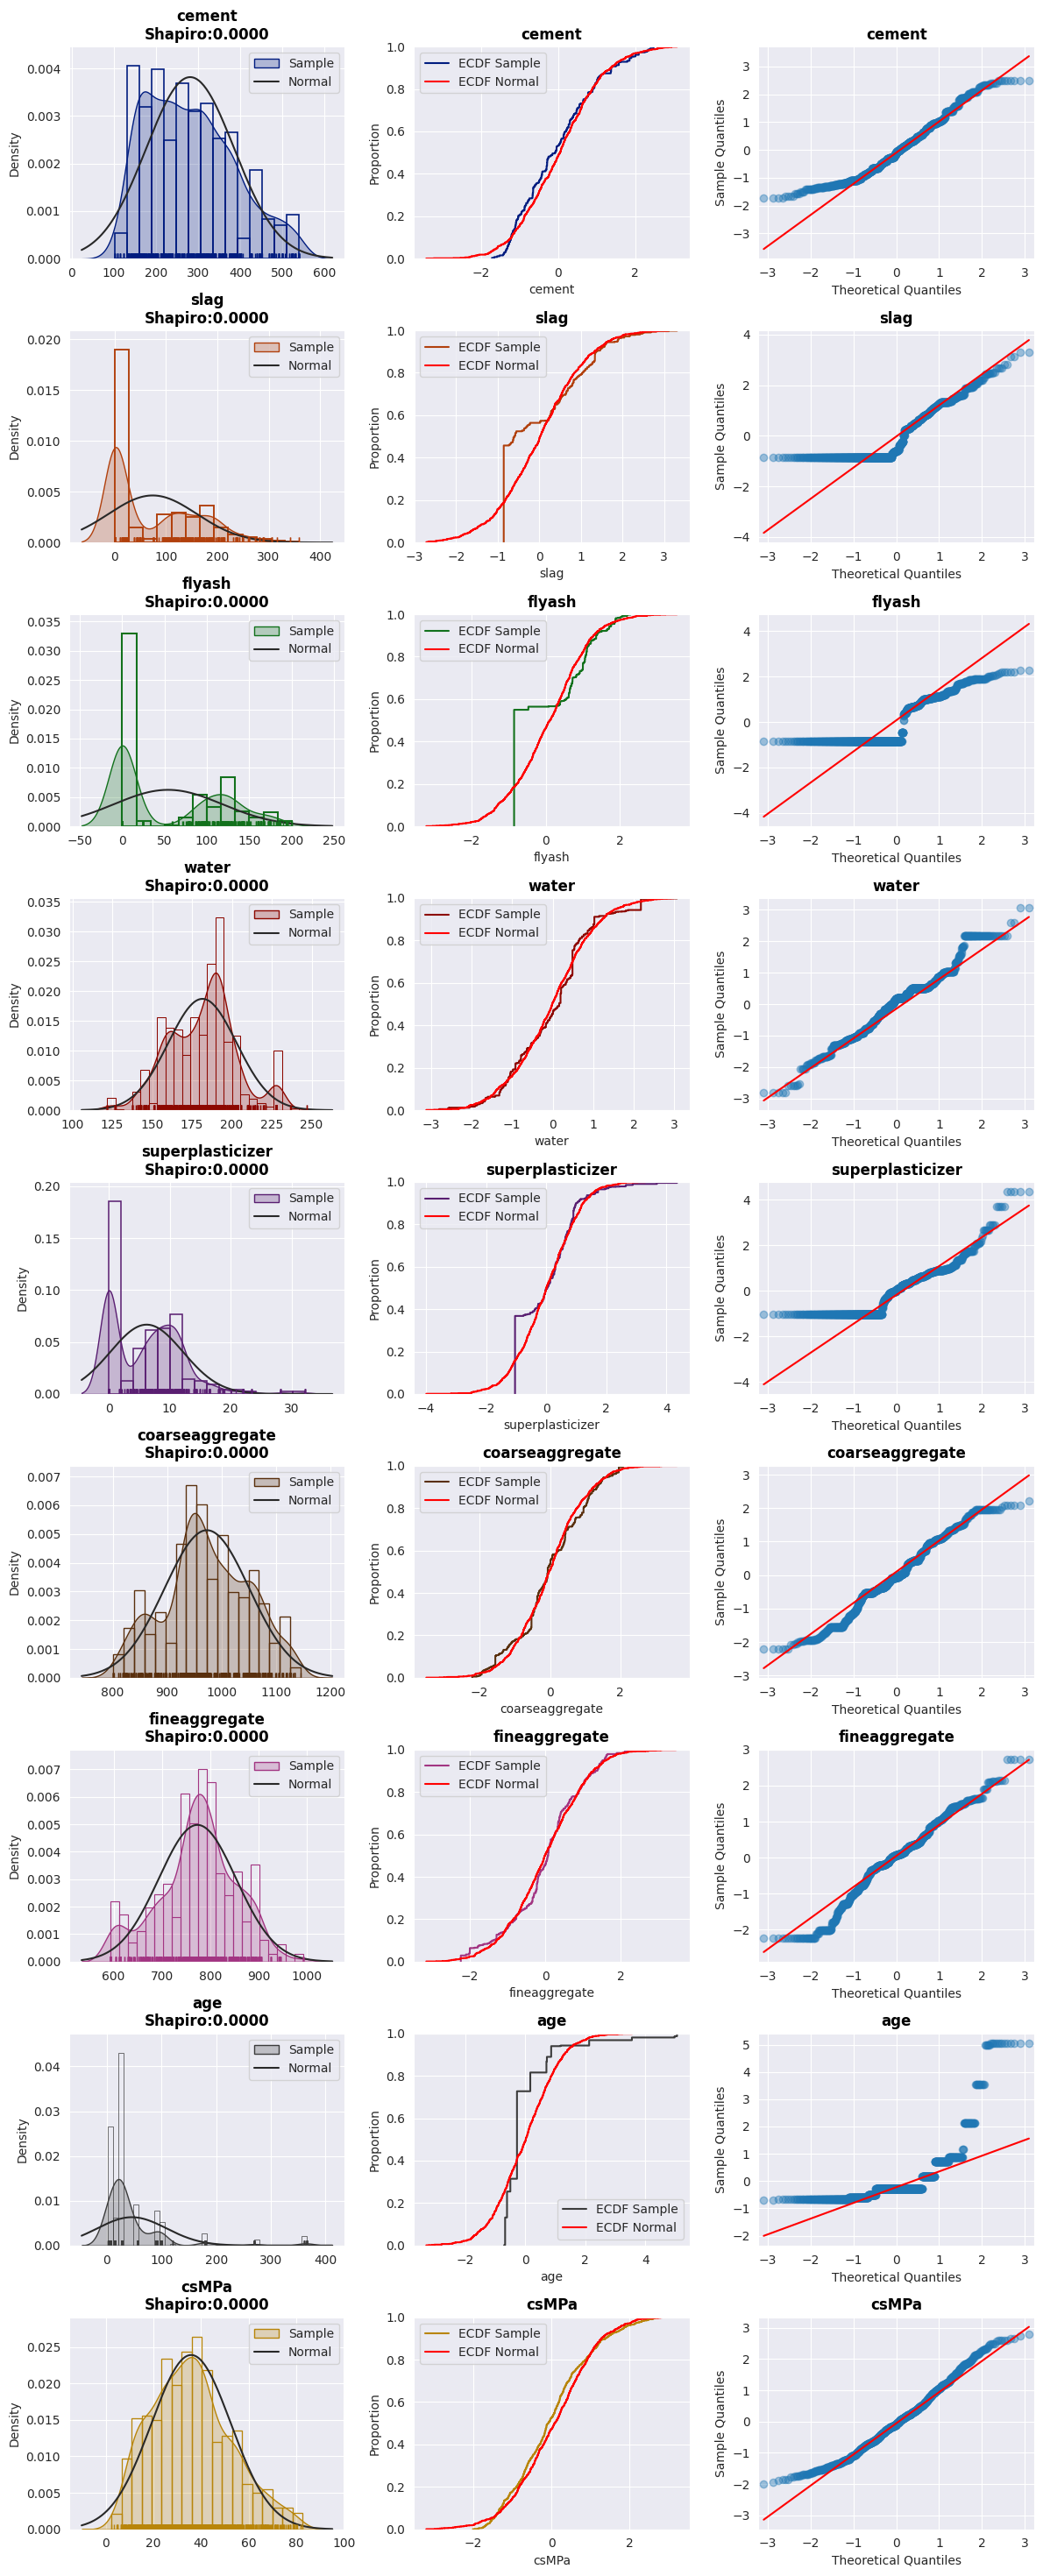

In [5]:
sns.set_style(style = "darkgrid")
colors = sns.color_palette(palette = "dark", n_colors = len(data.columns))

fig, axs = plt.subplots(nrows = 9, ncols = 3, figsize = (12, 29.5))

for i,col in enumerate(data.columns):
    
    # Histogram, Empirical PDF, Theorical PDF, Shapiro-Wilk
    sns.histplot(data = data, x = col, stat = 'density', fill = False, ax = axs[i, 0], color = colors[i])
    sns.kdeplot(data = data, x = col, fill = True, ax = axs[i, 0], color = colors[i], label = 'Sample')
    sns.distplot(data[col], hist = False, kde = False, fit = stats.norm, ax = axs[i, 0], label = 'Normal')
    sns.rugplot(data = data, x = col, ax = axs[i, 0], color = colors[i])
    axs[i, 0].set_title(f"{col}\nShapiro:{stats.shapiro(data['cement']).pvalue:.4f}", fontweight = 'bold', color = 'black')
    axs[i, 0].set_xlabel("")
    axs[i, 0].legend()
    
    # Empirical ECDF, Theorical ECDF
    mu, sigma = np.mean(data[col]), np.std(data[col], ddof=1)
    standardized_data = (data[col] - mu) / sigma
    sns.ecdfplot(standardized_data, ax = axs[i, 1], color = colors[i], label = 'ECDF Sample')
    sns.ecdfplot(np.random.standard_normal(1000), ax = axs[i, 1], color = 'red', label = 'ECDF Normal')
    axs[i, 1].set_title(f"{col}", fontweight = 'bold', color = 'black')
    axs[i, 1].legend()
    
    # QQ-plot
    sm.qqplot(data[col], line = 'q', ax = axs[i, 2], alpha = 0.4, fit = True)
    axs[i, 2].set_title(f"{col}", fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

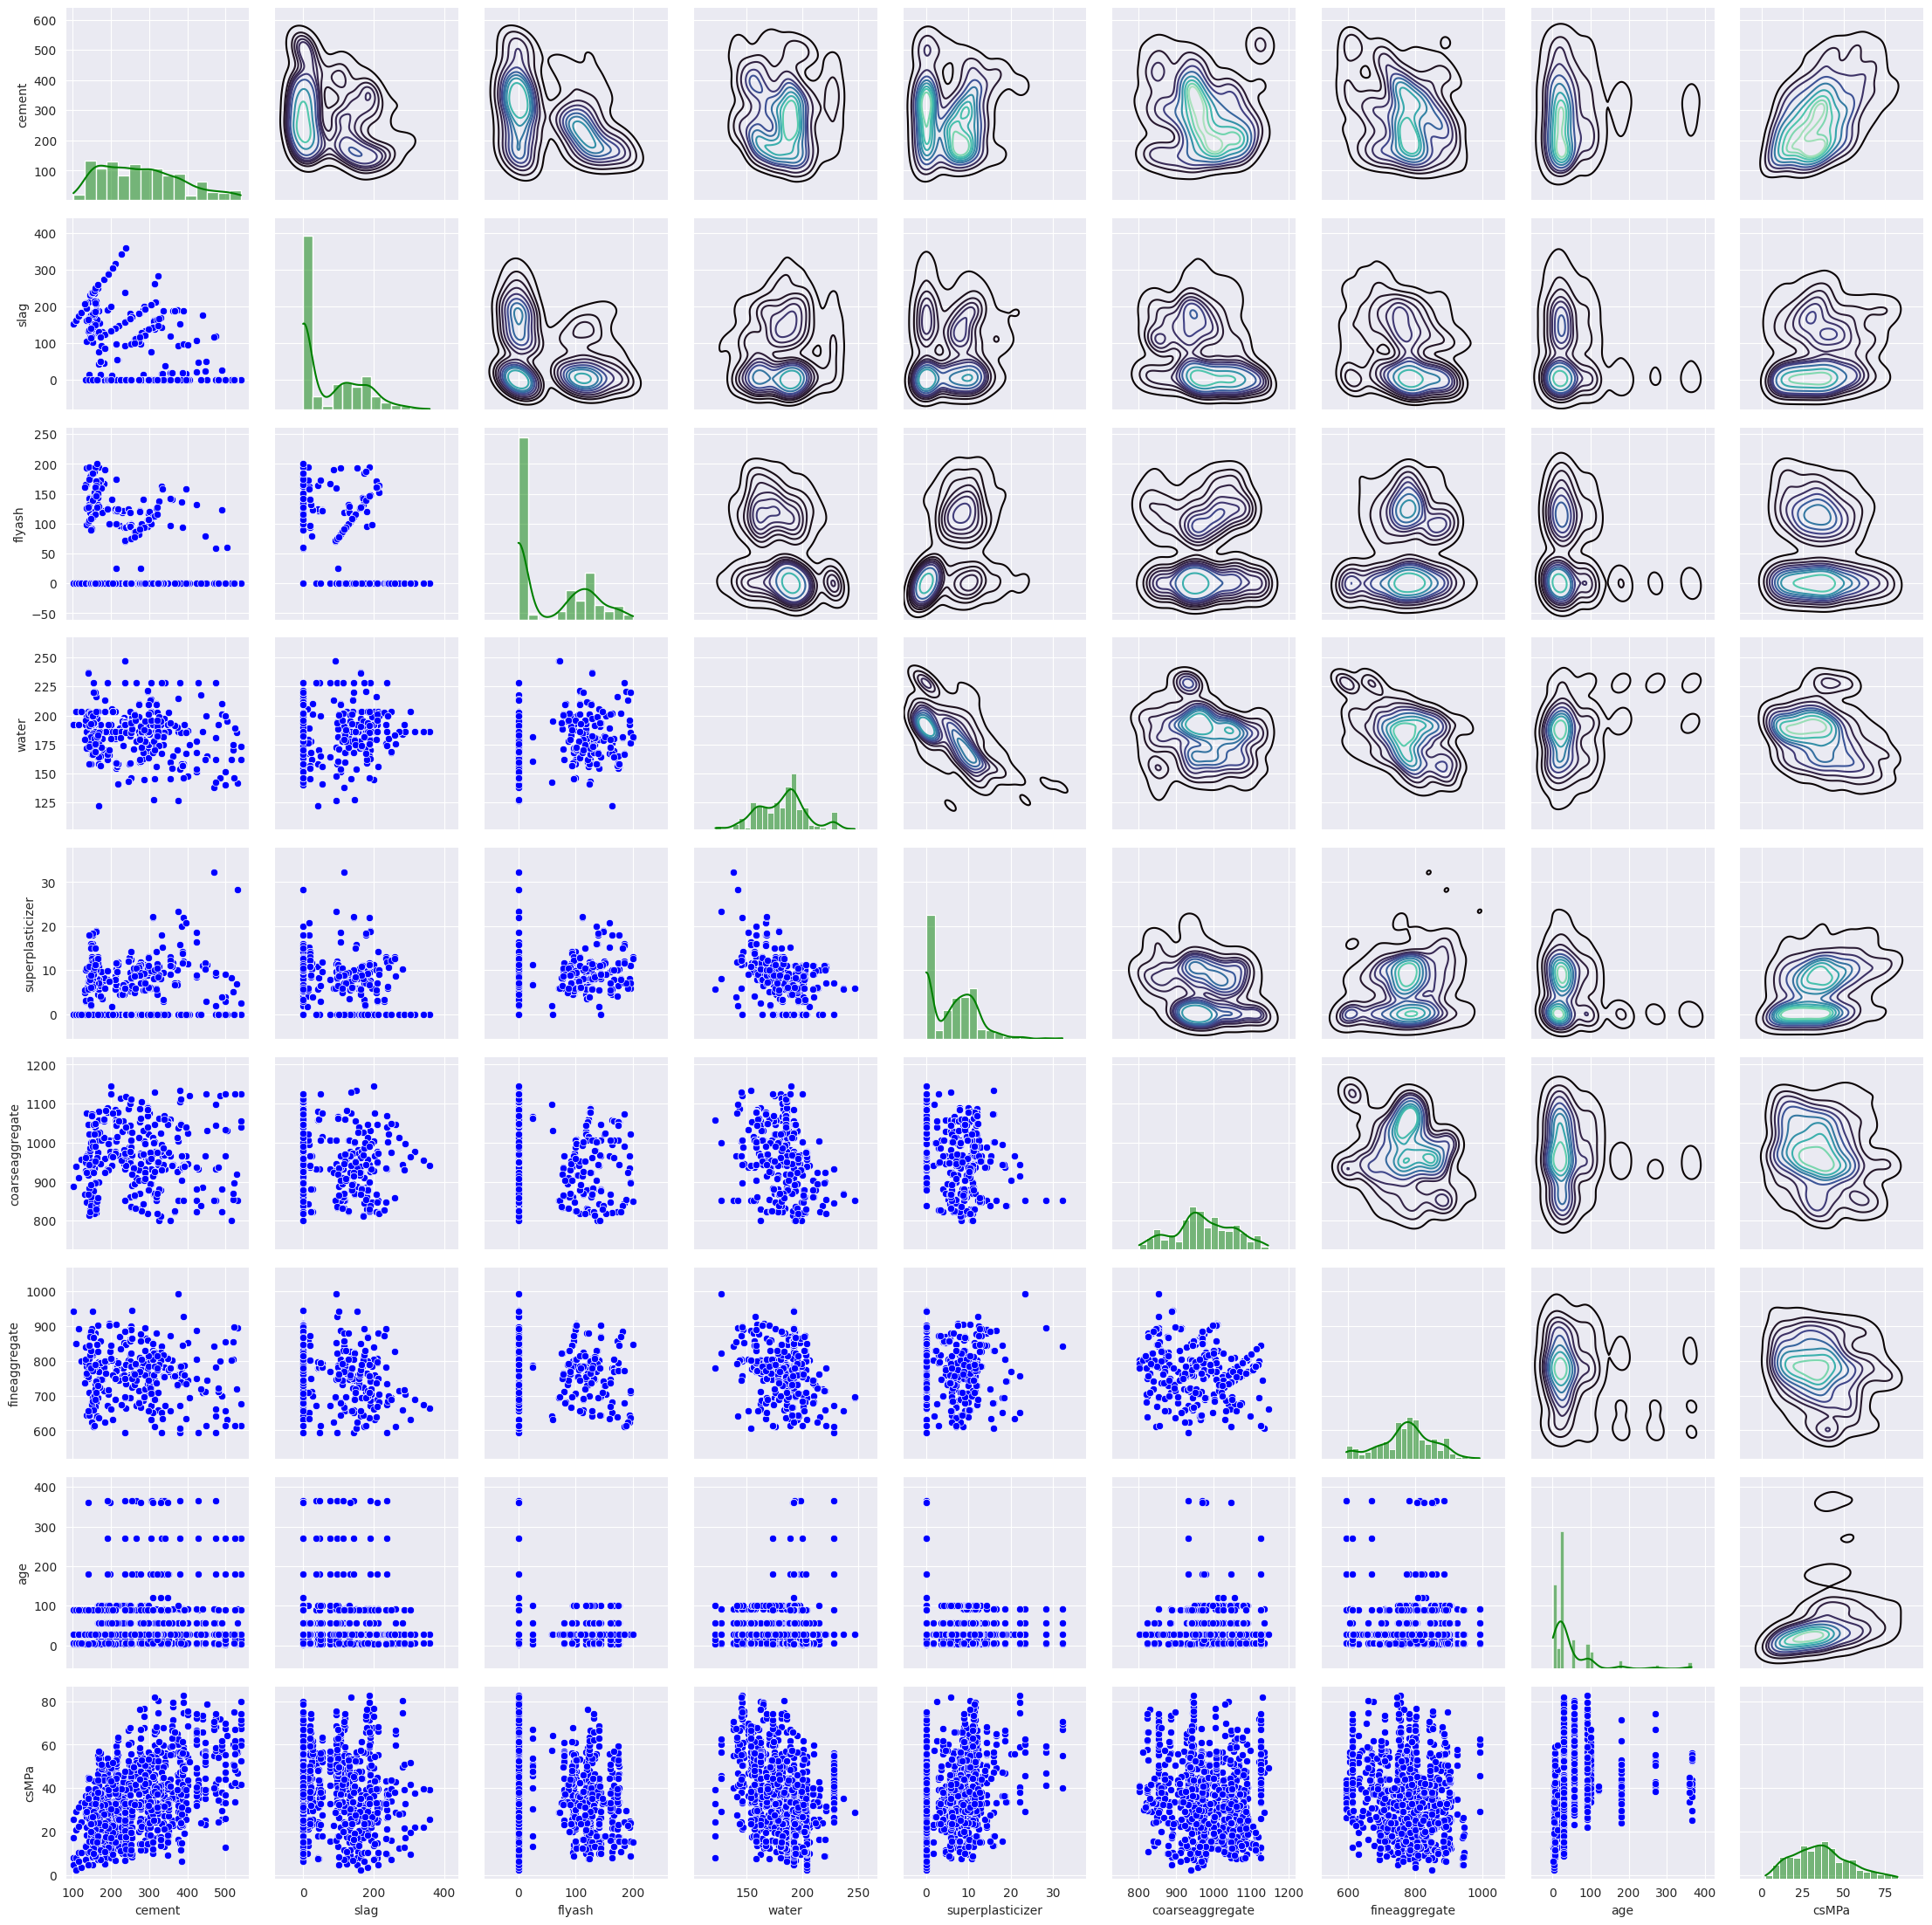

In [6]:
g = sns.PairGrid(data, palette = 'dark')
g.map_lower(sns.scatterplot, color = 'blue')
g.map_diag(sns.histplot, kde = True, color = 'green')
g.map_upper(sns.kdeplot, kde = True, cmap = 'mako')
g.fig.show()

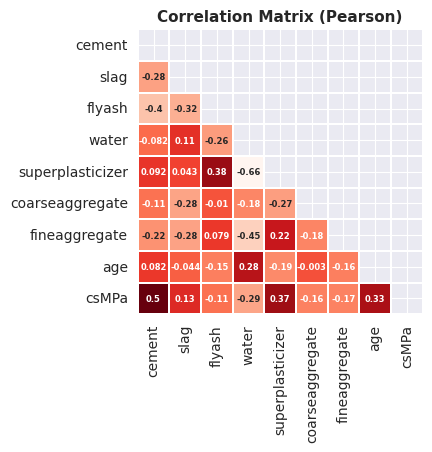

In [7]:
corr_matrix_pearson = data.corr(method = 'pearson')
mask = np.triu(np.ones_like(corr_matrix_pearson, dtype = bool))

fig,axs = plt.subplots(figsize = (7, 3.7))
sns.heatmap(corr_matrix_pearson, 
            cmap = 'Reds', 
            annot = True, 
            annot_kws = {'fontsize':6, 'fontweight':'bold'},
            linewidths = 1.1,
            square = True, 
            mask = mask, 
            cbar = False)
axs.set_title("Correlation Matrix (Pearson)", fontsize = 11, fontweight = 'bold')
fig.show()

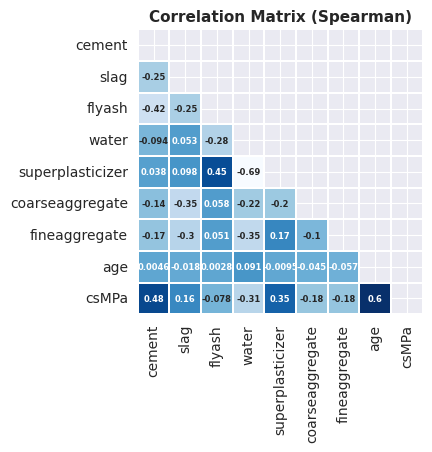

In [8]:
corr_matrix_spearman = data.corr(method = 'spearman')
mask = np.triu(np.ones_like(corr_matrix_spearman, dtype = bool))

fig,axs = plt.subplots(figsize = (7, 3.7))
sns.heatmap(corr_matrix_spearman, 
            cmap = 'Blues', 
            annot = True, 
            annot_kws = {'fontsize':6, 'fontweight':'bold'},
            linewidths = 1.1,
            square = True, 
            mask = mask, 
            cbar = False)
axs.set_title("Correlation Matrix (Spearman)", fontsize = 11, fontweight = 'bold')
fig.show()

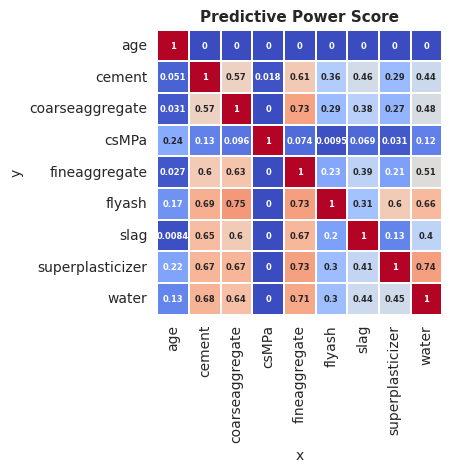

In [9]:
pps_matrix = pps.matrix(data)
pps_matrix = pps_matrix[['x', 'y', 'ppscore']].pivot_table(values = 'ppscore', 
                                                           index = 'y', 
                                                           columns = 'x')
fig,axs = plt.subplots(figsize = (7, 3.7))
sns.heatmap(pps_matrix, 
            cmap = 'coolwarm', 
            annot = True, 
            annot_kws = {'fontsize':6, 'fontweight':'bold'},
            linewidths = 1.1,
            square = True, 
            cbar = False)
axs.set_title("Predictive Power Score", fontsize = 11, fontweight = 'bold')
fig.show()

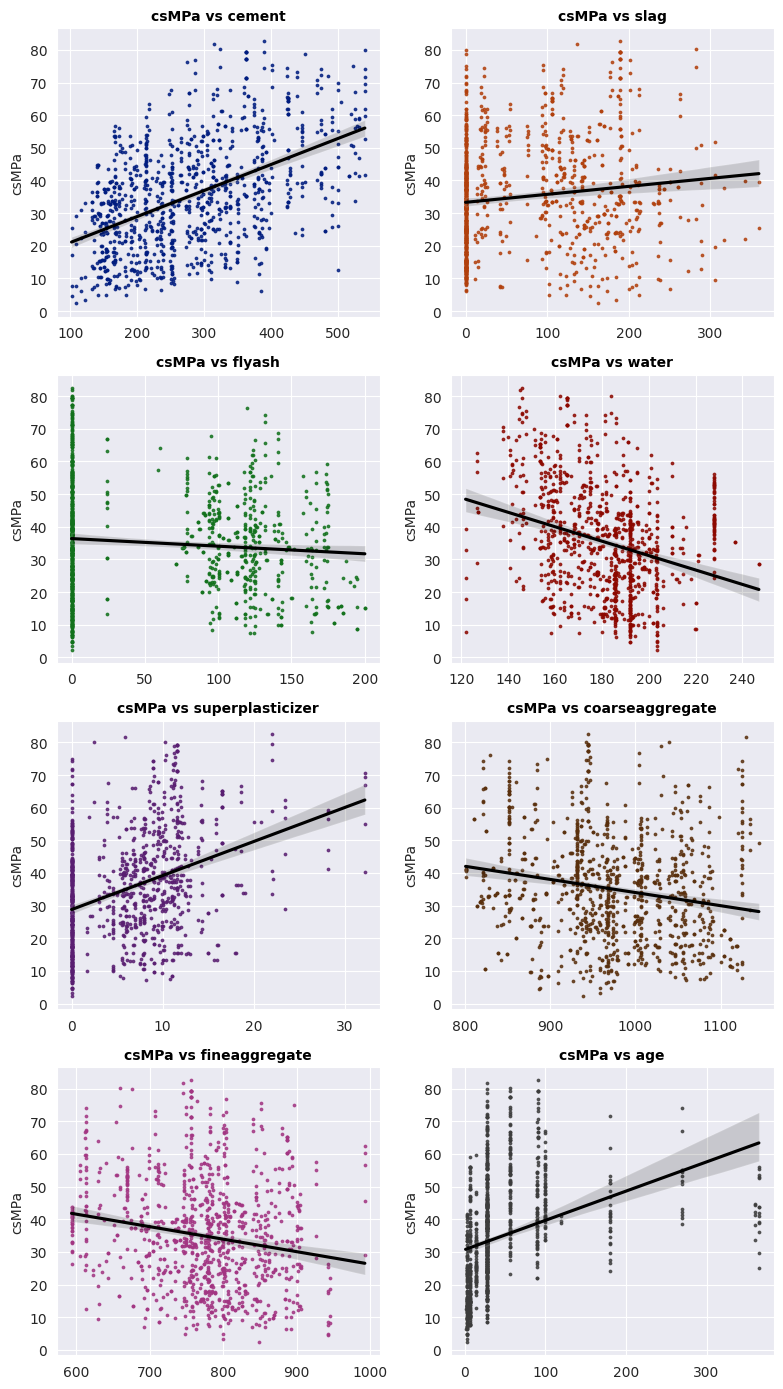

In [10]:
colors = sns.color_palette(palette = "dark", n_colors = len(data.columns[:-1]))

fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize = (8, 14))
axs = axs.flat

for i,col in enumerate(data.columns[:-1]):
    sns.regplot(x = data[col], y = data['csMPa'], robust = True, color = colors[i], scatter_kws = {'s':3}, line_kws = {'color':'black'}, ax = axs[i])
    axs[i].set_title(f"csMPa vs {col}", color = 'black', fontsize = 10, fontweight = 'bold')
    axs[i].set_xlabel("")
    
fig.tight_layout()
fig.show()

In [11]:
df_vif = {}

for i, col in enumerate(data.columns):
    df_vif[col] = vif(data, i)

df_vif = pd.DataFrame.from_dict(df_vif, orient = 'index')
df_vif = df_vif.rename(columns = {0:'VIF'}).sort_values(by = 'VIF', ascending = False)
df_vif.style.background_gradient(cmap = 'coolwarm')

,VIF
water,92.504056
coarseaggregate,85.896630
fineaggregate,73.514995
cement,26.232325
csMPa,14.557838
superplasticizer,5.519535
flyash,4.560002
slag,4.442518
age,2.434942


# **5. Data preprocessing**

In [12]:
X = data.drop(columns = ['csMPa'])
y = data['csMPa']

In [13]:
SEED = 123456
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = tts(X, 
                                       y, 
                                       test_size = TEST_SIZE, 
                                       random_state = SEED)

print(f"X_train: {len(y_train)} samples")
print(f"X_test: {len(y_test)} samples")

X_train: 824 samples
X_test: 206 samples


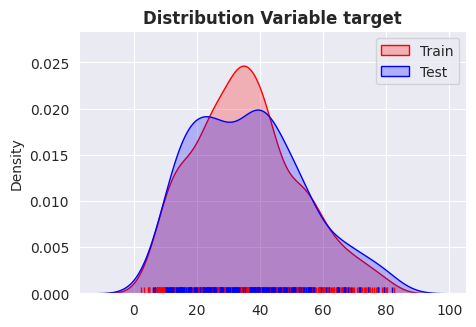

In [14]:
fig,ax = plt.subplots(figsize = (5, 3.4))
sns.kdeplot(y_train, label = 'Train', color = 'red', fill = True)
sns.rugplot(y_train, color = 'red')
sns.kdeplot(y_test, label = 'Test', color = 'blue', fill = True)
sns.rugplot(y_test, color = 'blue')
ax.set_xlabel("")
ax.set_title("Distribution Variable target", fontweight = 'bold')
ax.legend()
fig.show()

# **6. Regressors**

In [15]:
reg_1 = DecisionTreeRegressor(random_state = SEED)
reg_2 = RandomForestRegressor(random_state = SEED, n_jobs = -1)
reg_3 = ExtraTreesRegressor(random_state = SEED, bootstrap = True, n_jobs = -1)
reg_4 = GradientBoostingRegressor(random_state = SEED)
reg_5 = HistGradientBoostingRegressor(random_state = SEED)
reg_6 = XGBRegressor(random_state = SEED, n_jobs = -1)
reg_7 = LGBMRegressor(random_state = SEED, n_jobs = -1, verbosity = -1)
reg_8 = CatBoostRegressor(thread_count = -1, verbose = 0)

REGRESSORS = [reg_1, reg_2, reg_3, reg_4, reg_5, reg_6, reg_7, reg_8]

In [16]:
for model in tqdm(REGRESSORS):

    name = type(model).__name__
    
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print("==" * 40)
    print(" " * 25, f"{name}")
    print("==" * 40)
    print(f"MAE Train: {mae(y_train, y_pred_train):.4f} | MAE Test: {mae(y_test, y_pred_test):.4f} | R2 Train: {r2(y_train, y_pred_train):.4f} | R2 Test: {r2(y_test, y_pred_test):.4f}\n")

  0%|          | 0/8 [00:00<?, ?it/s]

                          DecisionTreeRegressor
MAE Train: 0.0895 | MAE Test: 4.2191 | R2 Train: 0.9959 | R2 Test: 0.8525

                          RandomForestRegressor
MAE Train: 1.2639 | MAE Test: 3.6031 | R2 Train: 0.9854 | R2 Test: 0.9061

                          ExtraTreesRegressor
MAE Train: 1.2762 | MAE Test: 3.5927 | R2 Train: 0.9852 | R2 Test: 0.9105

                          GradientBoostingRegressor
MAE Train: 2.7935 | MAE Test: 3.7280 | R2 Train: 0.9491 | R2 Test: 0.9071

                          HistGradientBoostingRegressor
MAE Train: 1.3844 | MAE Test: 3.0658 | R2 Train: 0.9822 | R2 Test: 0.9227

                          XGBRegressor
MAE Train: 0.3877 | MAE Test: 3.0132 | R2 Train: 0.9951 | R2 Test: 0.9266

                          LGBMRegressor
MAE Train: 1.3884 | MAE Test: 3.0798 | R2 Train: 0.9822 | R2 Test: 0.9247

                          CatBoostRegressor
MAE Train: 1.2125 | MAE Test: 2.6963 | R2 Train: 0.9870 | R2 Test: 0.9414



**Best model is `CatBoostRegressor`**

In [1]:
model = CatBoostRegressor(thread_count = -1, verbose = 0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

NameError: name 'CatBoostRegressor' is not defined

# **7. Residuals Plot**

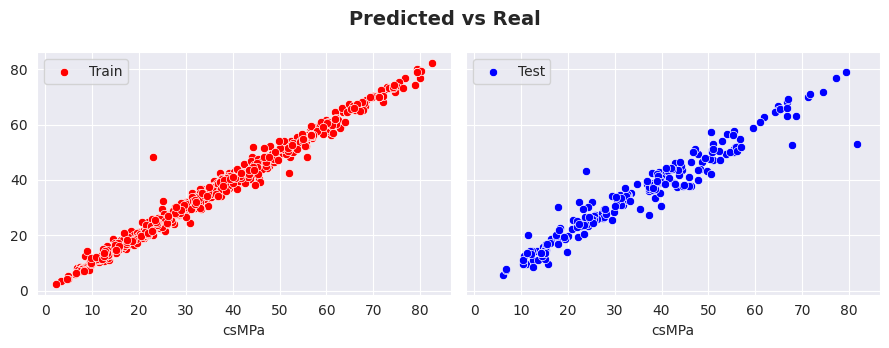

In [18]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 3.5), sharex = True, sharey = True)
sns.scatterplot(x = y_train, y = y_pred_train, ax = ax[0], color = 'red', label = "Train")

sns.scatterplot(x = y_test, y = y_pred_test, ax = ax[1], color = 'blue', label = "Test")

fig.suptitle("Predicted vs Real", fontsize = 14, fontweight = 'bold')
fig.tight_layout()
fig.show()

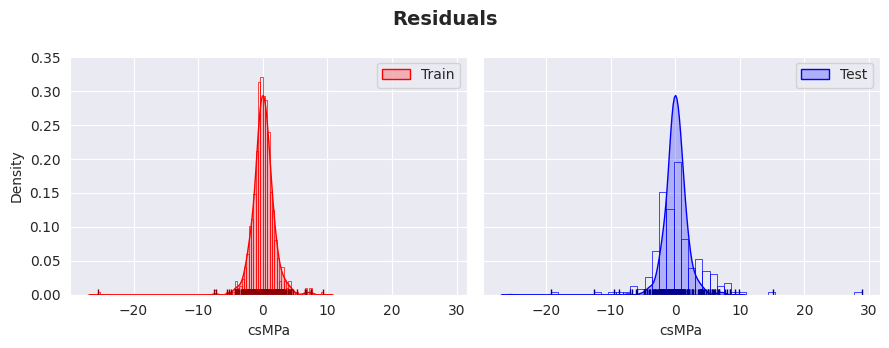

In [19]:
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 3.5), sharex = True, sharey = True)

sns.histplot(x = residuals_train, ax = ax[0], stat = 'density', fill = False, color = 'red')
sns.kdeplot(x = residuals_train, ax = ax[0], color = 'red', fill = True, label = "Train")
sns.rugplot(x = residuals_train, ax = ax[0], color = 'darkred')
ax[0].legend()

sns.histplot(x = residuals_test, ax = ax[1], stat = 'density', fill = False, color = 'blue')
sns.kdeplot(x = residuals_train, ax = ax[1], color = 'blue', fill = True, label = "Test")
sns.rugplot(x = residuals_test, ax = ax[1], color = 'darkblue')
ax[1].legend()

fig.suptitle("Residuals", fontsize = 14, fontweight = 'bold')
fig.tight_layout()
fig.show()

# **8. Hyperparameter Tuning**

In [28]:
def objective(trial):
    iterations = trial.suggest_int("iterations", 10, 1100, step = 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log = True)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-1, 20, log = True)
    subsample = trial.suggest_float("subsample", 1e-1, 1.0, log = True)
    random_seed = trial.suggest_int("random_seed", 0, 1000, step = 5)
    
    estimator = CatBoostRegressor(iterations = iterations, 
                                  learning_rate = learning_rate, 
                                  l2_leaf_reg = l2_leaf_reg, 
                                  subsample = subsample, 
                                  random_seed = random_seed, 
                                  thread_count = -1, 
                                  verbose = 0)
    
    scores = cvs(estimator, 
                 X = X_train, 
                 y = y_train, 
                 cv = KFold(n_splits = 5, shuffle = True, random_state = 0), 
                 scoring = 'neg_mean_absolute_error', 
                 n_jobs = -1)
    
    mae = - scores.mean()
    
    return mae

In [29]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(sampler = optuna.samplers.TPESampler(), direction = 'minimize')
study.optimize(objective, n_trials = 1000, n_jobs = 2, show_progress_bar = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
best_params_cb = study.best_params
best_params_cb

{'iterations': 1030,
 'learning_rate': 0.08335637369711002,
 'l2_leaf_reg': 0.6629471567236563,
 'subsample': 0.34988718285615256,
 'random_seed': 865}

In [31]:
model = CatBoostRegressor(**best_params_cb, thread_count = -1, verbose = 0)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"MAE Train: {mae(y_train, y_pred_train):.4f} | MAE Test: {mae(y_test, y_pred_test):.4f} | R2 Train: {r2(y_train, y_pred_train):.4f} | R2 Test: {r2(y_test, y_pred_test):.4f}")

MAE Train: 0.6505 | MAE Test: 2.5207 | R2 Train: 0.9936 | R2 Test: 0.9481


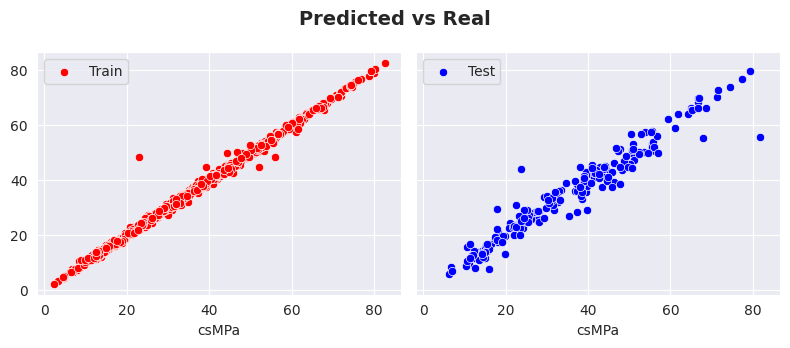

In [33]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 3.5), sharex = True, sharey = True)
sns.scatterplot(x = y_train, y = y_pred_train, ax = ax[0], color = 'red', label = "Train")

sns.scatterplot(x = y_test, y = y_pred_test, ax = ax[1], color = 'blue', label = "Test")

fig.suptitle("Predicted vs Real", fontsize = 14, fontweight = 'bold')
fig.tight_layout()
fig.show()

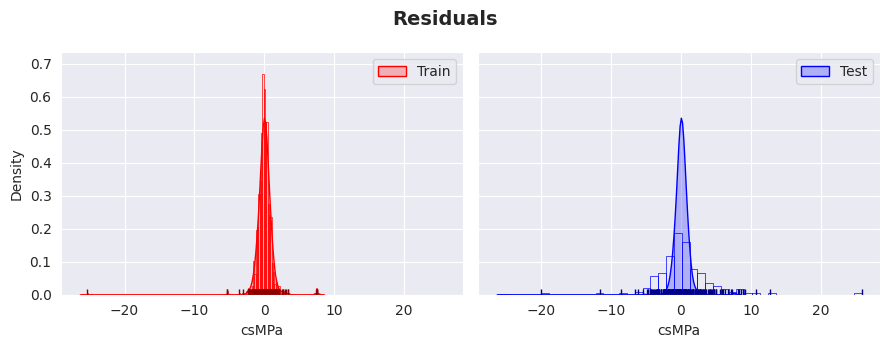

In [34]:
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 3.5), sharex = True, sharey = True)

sns.histplot(x = residuals_train, ax = ax[0], stat = 'density', fill = False, color = 'red')
sns.kdeplot(x = residuals_train, ax = ax[0], color = 'red', fill = True, label = "Train")
sns.rugplot(x = residuals_train, ax = ax[0], color = 'darkred')
ax[0].legend()

sns.histplot(x = residuals_test, ax = ax[1], stat = 'density', fill = False, color = 'blue')
sns.kdeplot(x = residuals_train, ax = ax[1], color = 'blue', fill = True, label = "Test")
sns.rugplot(x = residuals_test, ax = ax[1], color = 'darkblue')
ax[1].legend()

fig.suptitle("Residuals", fontsize = 14, fontweight = 'bold')
fig.tight_layout()
fig.show()